In [ ]:
#!git clone https://github.com/neuralcomputer/ML_School.git

# Тема № 25. Обучение метрических преобразований. 
Мы уже говорили про "расстояния", измеряли расстояния между точками, использовали расстояния для сравнения значений и т.п.
Но что такое расстояние? Это число, которое показывает нам некоторую меру отношения двух точек в пространстве, "близко" или "далеко". Такое число (обозначим **d()**) обладает свойствами, что для любых точек **x**, **y**, **z**:

- 1) d(x,y)= 0 тогда и только тогда, когда x=y.
- 2) d(x,y)=d(y,x) - симметрия, расстояние от точки х до точки у равно расстоянию от точки у до точки х.
- 3) \\( d(x,y) \leq d(x,z)+d(z,y) \\) - неравенство треугольника, показывающее, что расстояние от точки х до точки у не больше (меньше или равно) чем сумма расстояния от точки х до другой точки z и от точки z до точки у.  

Привычное нам Евклидово расстояние в N-мерном пространстве \\( d_{евклид} (x,y)=\sqrt{\sum_{i=1}^N (x_i-y_i)^2} \\) удовлетворяет таким условиям, но кроме него есть еще множество других способов задать расстояние, которое тоже будет удовлетворять таким условиям и значит "расстояние" можно измерять по другому и использовать их при обучении моделей.

Можно пойти дальше и обучать сами расстояния, т.е. делать такие способы расчета расстояний, которые помогли бы нам решать задачи. Давайте ограничимся случаями, когда расстояние считается как \\( D(x, y) = \sqrt{(L*x-L*y)^\top(L*x-L*y)}\\) , где L - некоторая матрица размера P * N, которая выполняет линейное преобразование и проекцию исходных векторов х и у в пространство меньшей размерности Р (если L - единичная квадратная матрица, то получится Евклидово расстояние). Эту же запись можно представить как  \\(D(x, y) = \sqrt{(x-y)^\top * M* (x-y)}, M=L^\top * L\\) с матрицей M. 

Задавая элементы матрицы получаем то или иное преобразование пространства, давайте подбирать (обучать) элементы матрицы так, чтобы проще решить задачу. Например для классификации, будем так подбирать элементы, чтобы точки одного класса оказались после преобразования как можно ближе друг к другу, а точки из разных классов как можно дальше друг от друга. Тогда в новом пространстве и классификацию будет выполнить проще.


Обучения метрических преобразований может использоваться во множестве случаев: 

- В модели К-ближайших соседей,
- Кластеризация, например с помощью K-Means,
- Поиск информации в базе данных которая семантически ближе к элементу запроса,
- Уменьшение размерности данных данных и др.

Вывод и понимание уравнений требует серьезной математической подготовки, поэтому мы только посмотрим на применение на практике, без теоретических деталей, но если вам интересно, то можно посмотреть раздел Algorithms в документации на библиотеку [`metric-learn`](http://contrib.scikit-learn.org/metric-learn/user_guide.html) которая совместима с `sklearn`.

Создадим набор данных, который будет содержать 100 объектов (точек) 3х классов с двумя кластерами на класс, у каждого объекта 5 признаков, три из которых информативные (связаны с метками класса) и две - случайный шум большой величины. Один из классов сильно пересекается с другими, это сложно классифицировать линейными классификаторами.

In [1]:
import numpy as np
from sklearn.datasets import make_classification, make_regression
# visualisation imports
import matplotlib.pyplot as plt
np.random.seed(42)

X, y = make_classification(n_samples=100, n_classes=3, n_clusters_per_class=2,
                           n_informative=3, class_sep=4., n_features=5,
                           n_redundant=0, shuffle=True,
                           scale=[1, 1, 20, 20, 20])

Для того, чтобы отобразить 5-мерные признаки на плоскости, воспользуемся уже известным нам методом PCA.

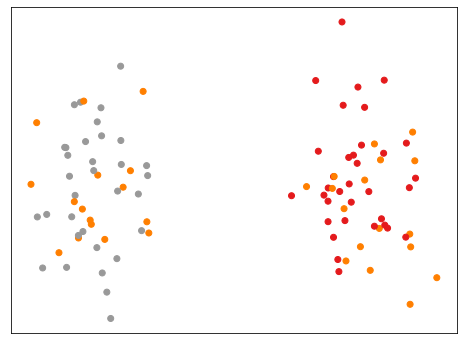

In [2]:
from sklearn.decomposition import PCA
np.random.seed(42)
pca = PCA()
X_embedded = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
colormap=plt.cm.Set1 # 
plt.clf()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)
plt.xticks(())
plt.yticks(())
plt.show()

Мы видим, что даже в главных компонентах классы кажутся смешанными.

## Метод LMNN

Метод LMNN, Large Margin Nearest Neighbour - это метрический алгоритм обучения, предназначенный в первую очередь для классификации с помощью метода k-ближайших соседей. Метод пытается построить такое преобразование, при котором все экземпляры данных в обучающем наборе окружены по крайней мере k экземплярами, имеющими одну и ту же метку класса. Если это достигается, то ошибка исключения одного из них сводится к минимуму. Это неявно принуждают точки из одного и того же класса объединяться вместе.

Реализован в [`metric_learn.LMNN`](http://contrib.scikit-learn.org/metric-learn/generated/metric_learn.LMNN.html?highlight=lmnn) из важных аргументов можно указать `k` - число соседей, а результат, матрица L, хранится в атрибуте `components_`, предоставляет методы `fit()`, `fit_transform()` и др.

In [4]:
# установим библиотеку
!pip install metric_learn

     |████████████████████████████████| 71kB 2.9MB/s 


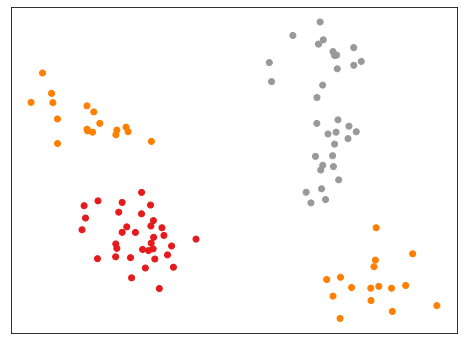

In [5]:
import metric_learn
# зададим параметры метода 
lmnn = metric_learn.LMNN(k=5, learn_rate=1e-6)
# обучим преобразование
lmnn.fit(X, y)
# переобразуем данные
X_lmnn = lmnn.transform(X)
# найдем главные компоненты для преобразованных данных
X_embedded = pca.fit_transform(X_lmnn)
# построим график
plt.figure(figsize=(8, 6))
colormap=plt.cm.Set1 # 
plt.clf()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=colormap)
plt.xticks(())
plt.yticks(())
plt.show()

Мы видим, что теперь классы разделились, и здесь достаточно линейного классификатора, чтобы решить задачу, что вы и сделаете самостоятельно.

Другие примеры по обучению метрических преобразований можно найти в [документации](http://contrib.scikit-learn.org/metric-learn/auto_examples/plot_metric_learning_examples.html#sphx-glr-auto-examples-plot-metric-learning-examples-py)
